In [1]:
import cv2
import numpy as np
from tqdm import tqdm
import os
REBUILD_DATA = True

class DogsVsCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print("label = ", self.LABELS[label])
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot 
                        
                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1
                            
                    except Exception as e:
                        pass
                    
        np.random.shuffle(self.training_data)
        np.save("data.npy", self.training_data)
        print(f"Cats: {self.catcount}")
        print(f"Dogs: {self.dogcount}")

if REBUILD_DATA:
    dogsvcats = DogsVsCats()
    dogsvcats.make_training_data()
                

label =  0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12501/12501 [00:08<00:00, 1489.69it/s]


label =  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12501/12501 [00:09<00:00, 1381.22it/s]
/Users/manosriram/dev/nn/nn/lib/python3.10/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Cats: 12476
Dogs: 12470


In [3]:
training_data = np.load("data.npy", allow_pickle=True)

In [4]:
import torch

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

/Users/manosriram/dev/nn/nn/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/nt/ql39p2313mz9qzr0twnqxkmm0000gn/T/ipykernel_7671/3628659862.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  X = torch.Tensor([i[0] for i in training_data]).view(-1, 50,50)


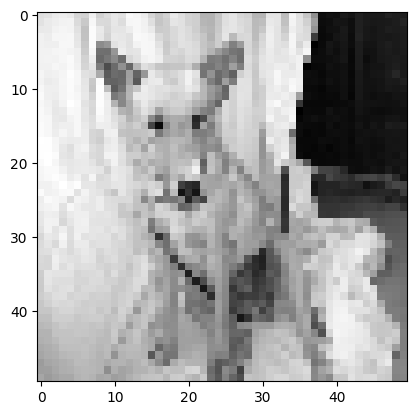

In [5]:
import matplotlib.pyplot as plt

plt.imshow(X[0], cmap="gray")

In [9]:
torch.rand(50, 50).view(-1, 1, 50, 50)

tensor([[[[0.8593, 0.0246, 0.0275,  ..., 0.7892, 0.3762, 0.0720],
          [0.3296, 0.0182, 0.7235,  ..., 0.7368, 0.9946, 0.9047],
          [0.4670, 0.2061, 0.5481,  ..., 0.5579, 0.2950, 0.1657],
          ...,
          [0.0800, 0.2667, 0.7324,  ..., 0.7850, 0.3771, 0.8262],
          [0.0479, 0.7888, 0.7991,  ..., 0.1365, 0.5025, 0.5556],
          [0.0788, 0.5193, 0.5351,  ..., 0.7441, 0.7106, 0.8048]]]])

In [41]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self._to_linear = None


        x = torch.rand(50, 50).view(-1, 1, 50, 50)
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.  (F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        
        print(x[0].shape)
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
            
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.softmax(x, dim=1)
            
net = Net()

torch.Size([128, 2, 2])


In [29]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
VAL_SIZE = int(len(X) * VAL_PCT)
print(VAL_SIZE)

2494


In [36]:
train_x = X[:-VAL_SIZE]
train_y = y[:-VAL_SIZE]
test_x = X[-VAL_SIZE:]
test_y = y[-VAL_SIZE:]

In [42]:
BATCH_SIZE = 100
EPOCHS = 1

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_x), BATCH_SIZE)):
        batch_X = train_x[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]
        net.zero_grad()
        outputs = net(batch_X)
                                               
                                               
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
                                               
print(loss)

  0%|▌                                                                                                                        | 1/225 [00:00<00:41,  5.38it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  1%|█▌                                                                                                                       | 3/225 [00:00<00:30,  7.26it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  2%|██▋                                                                                                                      | 5/225 [00:00<00:28,  7.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  3%|███▊                                                                                                                     | 7/225 [00:00<00:27,  7.98it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  4%|████▊                                                                                                                    | 9/225 [00:01<00:26,  8.04it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  5%|█████▊                                                                                                                  | 11/225 [00:01<00:26,  8.12it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  6%|██████▉                                                                                                                 | 13/225 [00:01<00:25,  8.16it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  7%|████████                                                                                                                | 15/225 [00:01<00:25,  8.20it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  8%|█████████                                                                                                               | 17/225 [00:02<00:25,  8.18it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  8%|██████████▏                                                                                                             | 19/225 [00:02<00:25,  8.21it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  9%|███████████▏                                                                                                            | 21/225 [00:02<00:25,  8.15it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 10%|████████████▎                                                                                                           | 23/225 [00:02<00:24,  8.14it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 11%|█████████████▎                                                                                                          | 25/225 [00:03<00:24,  8.09it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 12%|██████████████▍                                                                                                         | 27/225 [00:03<00:24,  8.13it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 13%|███████████████▍                                                                                                        | 29/225 [00:03<00:24,  7.99it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 14%|████████████████▌                                                                                                       | 31/225 [00:03<00:24,  8.05it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 15%|█████████████████▌                                                                                                      | 33/225 [00:04<00:23,  8.12it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|██████████████████▋                                                                                                     | 35/225 [00:04<00:23,  8.15it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|███████████████████▋                                                                                                    | 37/225 [00:04<00:23,  8.15it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 17%|████████████████████▊                                                                                                   | 39/225 [00:04<00:23,  8.07it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 18%|█████████████████████▊                                                                                                  | 41/225 [00:05<00:22,  8.14it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 19%|██████████████████████▉                                                                                                 | 43/225 [00:05<00:22,  8.19it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 20%|████████████████████████                                                                                                | 45/225 [00:05<00:22,  8.13it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 21%|█████████████████████████                                                                                               | 47/225 [00:05<00:21,  8.18it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 22%|██████████████████████████▏                                                                                             | 49/225 [00:06<00:21,  8.16it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 23%|███████████████████████████▏                                                                                            | 51/225 [00:06<00:21,  8.14it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 24%|████████████████████████████▎                                                                                           | 53/225 [00:06<00:21,  8.14it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 24%|█████████████████████████████▎                                                                                          | 55/225 [00:06<00:20,  8.20it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 25%|██████████████████████████████▍                                                                                         | 57/225 [00:07<00:20,  8.14it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 26%|███████████████████████████████▍                                                                                        | 59/225 [00:07<00:20,  8.20it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 27%|████████████████████████████████▌                                                                                       | 61/225 [00:07<00:20,  8.20it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|█████████████████████████████████▌                                                                                      | 63/225 [00:07<00:19,  8.17it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 29%|██████████████████████████████████▋                                                                                     | 65/225 [00:08<00:19,  8.20it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 30%|███████████████████████████████████▋                                                                                    | 67/225 [00:08<00:19,  8.15it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 31%|████████████████████████████████████▊                                                                                   | 69/225 [00:08<00:19,  8.12it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 32%|█████████████████████████████████████▊                                                                                  | 71/225 [00:08<00:18,  8.12it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 32%|██████████████████████████████████████▉                                                                                 | 73/225 [00:09<00:18,  8.10it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 33%|████████████████████████████████████████                                                                                | 75/225 [00:09<00:18,  8.12it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 34%|█████████████████████████████████████████                                                                               | 77/225 [00:09<00:18,  8.11it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 35%|██████████████████████████████████████████▏                                                                             | 79/225 [00:09<00:18,  8.07it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 36%|███████████████████████████████████████████▏                                                                            | 81/225 [00:10<00:18,  7.95it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 37%|████████████████████████████████████████████▎                                                                           | 83/225 [00:10<00:17,  7.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 38%|█████████████████████████████████████████████▎                                                                          | 85/225 [00:10<00:18,  7.66it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 39%|██████████████████████████████████████████████▍                                                                         | 87/225 [00:10<00:18,  7.59it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|███████████████████████████████████████████████▍                                                                        | 89/225 [00:11<00:17,  7.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|████████████████████████████████████████████████▌                                                                       | 91/225 [00:11<00:17,  7.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 41%|█████████████████████████████████████████████████▌                                                                      | 93/225 [00:11<00:16,  7.98it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 42%|██████████████████████████████████████████████████▋                                                                     | 95/225 [00:11<00:18,  6.87it/s]

torch.Size([128, 2, 2])


 43%|███████████████████████████████████████████████████▏                                                                    | 96/225 [00:12<00:19,  6.71it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 44%|████████████████████████████████████████████████████▎                                                                   | 98/225 [00:12<00:17,  7.07it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 44%|████████████████████████████████████████████████████▉                                                                  | 100/225 [00:12<00:16,  7.45it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 45%|█████████████████████████████████████████████████████▉                                                                 | 102/225 [00:12<00:15,  7.72it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 46%|███████████████████████████████████████████████████████                                                                | 104/225 [00:13<00:15,  7.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 47%|████████████████████████████████████████████████████████                                                               | 106/225 [00:13<00:14,  8.02it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 48%|█████████████████████████████████████████████████████████                                                              | 108/225 [00:13<00:14,  8.02it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 49%|██████████████████████████████████████████████████████████▏                                                            | 110/225 [00:13<00:14,  7.95it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 50%|███████████████████████████████████████████████████████████▏                                                           | 112/225 [00:14<00:14,  8.02it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 51%|████████████████████████████████████████████████████████████▎                                                          | 114/225 [00:14<00:13,  7.94it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 52%|█████████████████████████████████████████████████████████████▎                                                         | 116/225 [00:14<00:13,  7.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 52%|██████████████████████████████████████████████████████████████▍                                                        | 118/225 [00:14<00:13,  7.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 53%|███████████████████████████████████████████████████████████████▍                                                       | 120/225 [00:15<00:13,  7.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 54%|████████████████████████████████████████████████████████████████▌                                                      | 122/225 [00:15<00:13,  7.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 55%|█████████████████████████████████████████████████████████████████▌                                                     | 124/225 [00:15<00:12,  7.81it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|██████████████████████████████████████████████████████████████████▋                                                    | 126/225 [00:15<00:12,  7.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 57%|███████████████████████████████████████████████████████████████████▋                                                   | 128/225 [00:16<00:12,  7.99it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 58%|████████████████████████████████████████████████████████████████████▊                                                  | 130/225 [00:16<00:11,  8.01it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 59%|█████████████████████████████████████████████████████████████████████▊                                                 | 132/225 [00:16<00:11,  8.00it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 60%|██████████████████████████████████████████████████████████████████████▊                                                | 134/225 [00:16<00:11,  7.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 60%|███████████████████████████████████████████████████████████████████████▉                                               | 136/225 [00:17<00:11,  7.63it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 61%|████████████████████████████████████████████████████████████████████████▉                                              | 138/225 [00:17<00:11,  7.75it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 62%|██████████████████████████████████████████████████████████████████████████                                             | 140/225 [00:17<00:10,  7.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 63%|███████████████████████████████████████████████████████████████████████████                                            | 142/225 [00:17<00:10,  7.88it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 64%|████████████████████████████████████████████████████████████████████████████▏                                          | 144/225 [00:18<00:10,  7.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 65%|█████████████████████████████████████████████████████████████████████████████▏                                         | 146/225 [00:18<00:10,  7.36it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 66%|██████████████████████████████████████████████████████████████████████████████▎                                        | 148/225 [00:18<00:10,  7.36it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 67%|███████████████████████████████████████████████████████████████████████████████▎                                       | 150/225 [00:18<00:09,  7.54it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|████████████████████████████████████████████████████████████████████████████████▍                                      | 152/225 [00:19<00:09,  7.51it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|█████████████████████████████████████████████████████████████████████████████████▍                                     | 154/225 [00:19<00:09,  7.37it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 69%|██████████████████████████████████████████████████████████████████████████████████▌                                    | 156/225 [00:19<00:09,  7.54it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 70%|███████████████████████████████████████████████████████████████████████████████████▌                                   | 158/225 [00:20<00:08,  7.79it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 71%|████████████████████████████████████████████████████████████████████████████████████▌                                  | 160/225 [00:20<00:08,  7.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|█████████████████████████████████████████████████████████████████████████████████████▋                                 | 162/225 [00:20<00:07,  7.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 73%|██████████████████████████████████████████████████████████████████████████████████████▋                                | 164/225 [00:20<00:07,  7.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 74%|███████████████████████████████████████████████████████████████████████████████████████▊                               | 166/225 [00:21<00:07,  7.91it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 75%|████████████████████████████████████████████████████████████████████████████████████████▊                              | 168/225 [00:21<00:07,  7.94it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 76%|█████████████████████████████████████████████████████████████████████████████████████████▉                             | 170/225 [00:21<00:06,  7.97it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 76%|██████████████████████████████████████████████████████████████████████████████████████████▉                            | 172/225 [00:21<00:06,  7.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 77%|████████████████████████████████████████████████████████████████████████████████████████████                           | 174/225 [00:22<00:06,  7.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 78%|█████████████████████████████████████████████████████████████████████████████████████████████                          | 176/225 [00:22<00:06,  7.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 79%|██████████████████████████████████████████████████████████████████████████████████████████████▏                        | 178/225 [00:22<00:05,  7.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|███████████████████████████████████████████████████████████████████████████████████████████████▏                       | 180/225 [00:22<00:05,  7.95it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 81%|████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 182/225 [00:23<00:05,  7.98it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 184/225 [00:23<00:05,  7.96it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 186/225 [00:23<00:04,  7.97it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 188/225 [00:23<00:04,  7.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 190/225 [00:24<00:04,  7.66it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 192/225 [00:24<00:04,  7.76it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 194/225 [00:24<00:03,  7.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 196/225 [00:24<00:03,  7.93it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 198/225 [00:25<00:03,  7.99it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 200/225 [00:25<00:03,  8.01it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 202/225 [00:25<00:02,  8.03it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 204/225 [00:25<00:02,  7.99it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 206/225 [00:26<00:02,  8.02it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 208/225 [00:26<00:02,  7.97it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 210/225 [00:26<00:02,  7.38it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 212/225 [00:26<00:01,  7.45it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 214/225 [00:27<00:01,  7.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 216/225 [00:27<00:01,  7.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 218/225 [00:27<00:00,  7.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 220/225 [00:27<00:00,  7.54it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 222/225 [00:28<00:00,  7.54it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:28<00:00,  7.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
tensor(0.2495, grad_fn=<MseLossBackward0>)


In [47]:
with torch.no_grad():
    total = 0
    correct = 0
    for i in tqdm(range(len(test_x))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_x[i].view(-1, 1, 50, 50)[0])
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
        total += 1

    print(f"Accuracy: {correct/total}")

 10%|████████████                                                                                                        | 258/2494 [00:00<00:01, 1335.95it/s]

torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([

 23%|██████████████████████████▌                                                                                         | 570/2494 [00:00<00:01, 1488.98it/s]

torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([

 36%|█████████████████████████████████████████▍                                                                          | 891/2494 [00:00<00:01, 1554.34it/s]

torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([

 49%|███████████████████████████████████████████████████████▉                                                           | 1213/2494 [00:00<00:00, 1581.34it/s]

torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([

 62%|██████████████████████████████████████████████████████████████████████▊                                            | 1535/2494 [00:01<00:00, 1593.77it/s]

torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([

 74%|█████████████████████████████████████████████████████████████████████████████████████▍                             | 1854/2494 [00:01<00:00, 1579.63it/s]

torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([

 81%|████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2012/2494 [00:01<00:00, 1551.42it/s]

torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2331/2494 [00:01<00:00, 1571.01it/s]

torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2494/2494 [00:01<00:00, 1542.15it/s]

torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
Accuracy: 0.5096230954290297


In [72]:
print(test_y[1142])
net_out = net(test_x[1142].view(-1, 1, 50, 50)[0])
print(net_out)

tensor([1., 0.])
torch.Size([2, 2])
tensor([[0.5077, 0.4923]], grad_fn=<SoftmaxBackward0>)
